In [3]:
import sys
sys.path.append("..")
import numpy as np
data = np.load("../data/parchments.npz")
spectrums = data['x']
labels = data['labels']

In [117]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(in_features, 64)
        self.l2 = nn.Linear(64, 32)
        self.l3 = nn.Linear(32, out_features)
    def forward(self, X):
        X = torch.tanh(self.l1(X))
        Y = torch.relu(self.l2(X))
        X = torch.tanh(self.l3(Y))
        return X, Y

class Decoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(in_features, 32)
        self.l2 = nn.Linear(32, 64)
        self.l3 = nn.Linear(64, out_features)

    def forward(self, X):
        X = torch.tanh(self.l1(X))
        X = torch.relu(self.l2(X))
        X = torch.tanh(self.l3(X))
        return X

class AutoEncoder(nn.Module):
    def __init__(self, features, latent_features=2, variationnal=False):
        super(AutoEncoder, self).__init__()
        if variationnal:
            self.enc = Encoder(features, latent_features*2)
            self.dec = Decoder(latent_features, features)
        else:
            self.enc = Encoder(features, latent_features)
            self.dec = Decoder(latent_features, features)

        self.l1 = nn.Linear(32, 32)
        self.l2 = nn.Linear(32, 3)

        self.latent_features = latent_features
        self.variationnal = variationnal
    def forward(self, X):
        if self.variationnal:
            X, Y = self.enc(X)
            X = X.view(-1, 2, self.latent_features)
            mu = X[:, 0, :]
            logvar = (X[:, 1, :] - 1) * 5
            X = self.reparameterize(mu, logvar)
            Y = torch.log_softmax(self.l2(torch.tanh(self.l1(Y))), 1)
            return self.dec(X), mu, logvar, Y
        else:
            X, Y = self.dec(self.enc(X))
            Y = torch.log_softmax(self.l2(torch.tanh(self.l1(Y))), 1)
            return X, Y
    
    def encode(self, X, std=False):
        code, Y = self.enc(X)
        classif = torch.log_softmax(self.l2(torch.tanh(self.l1(Y))), 1)
        if self.variationnal:
            view = code.view(-1, 2, self.latent_features)
            if std:
                return view[:, 0, :], view[:, 1, :]
            else:
                return view[:, 0, :], classif
        else:
            return self.enc(X)

    def classify(self, X):
        _, Y = self.enc(X)
        return torch.log_softmax(self.l2(torch.tanh(self.l1(Y))), 1)
    def reparameterize(self, latent_mean, latent_logvar):
        std = torch.exp(0.5*latent_logvar)
        eps = torch.randn_like(std)
        sample = latent_mean + (eps * std)
        return sample

4.19669698893553


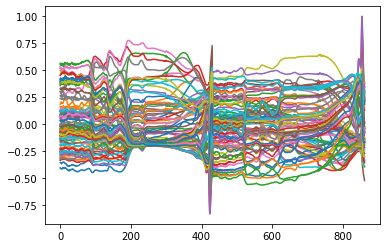

In [107]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = spectrums[:,:, ::5]
x /= x.max()
xs = scaler.fit_transform(x.reshape(x.shape[0], -1))
print(xs.max())
xs /= xs.max()
import matplotlib.pyplot as plt
for i in range(spectrums.shape[0]):
    plt.plot(xs[i, :])
from torch.utils.data import TensorDataset, DataLoader
ds = TensorDataset(torch.from_numpy(xs).type(torch.float), torch.from_numpy(labels[:, 0]).type(torch.long))
loader = DataLoader(ds, batch_size=8, shuffle=True)

In [108]:
labels[0, 0]

1

0.04295482723550363: 100%|██████████| 300/300 [00:18<00:00, 16.65it/s] 


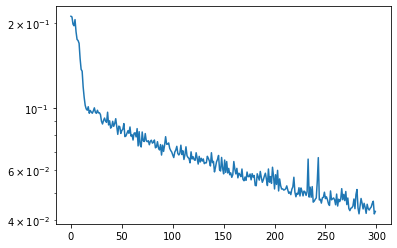

In [180]:
mse_loss = nn.L1Loss()
nllloss = nn.NLLLoss()
ae = AutoEncoder(xs.shape[1], 2, variationnal=True)
from torch.optim import Adam
optim = Adam(ae.parameters(), lr=5e-4, weight_decay=1e-4)
num_epochs = 300
from tqdm import trange
progress_bar = trange(num_epochs)
profile = []
for epoch in progress_bar:
    epoch_loss = 0.0
    for X, Y in loader:
        optim.zero_grad()
        Xp, mu, logvar, classif = ae(X)
        recons_loss = mse_loss(Xp, X)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        (recons_loss+kld_loss*0.0000+2*nllloss(classif, Y)).backward()
        optim.step()

        epoch_loss += recons_loss.item()
    epoch_loss /= len(loader)
    profile.append(epoch_loss)
    progress_bar.set_description_str(f"{epoch_loss}")
plt.semilogy(profile)
    

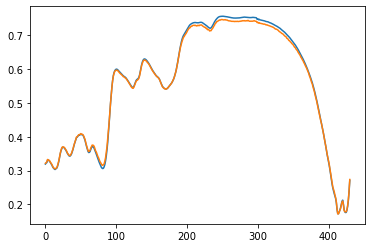

In [181]:
plt.plot(scaler.inverse_transform(X[0].detach().numpy()[np.newaxis, :]).reshape(2, -1)[1])
plt.plot(scaler.inverse_transform(Xp[0].detach().numpy()[np.newaxis, :]).reshape(2, -1)[1])

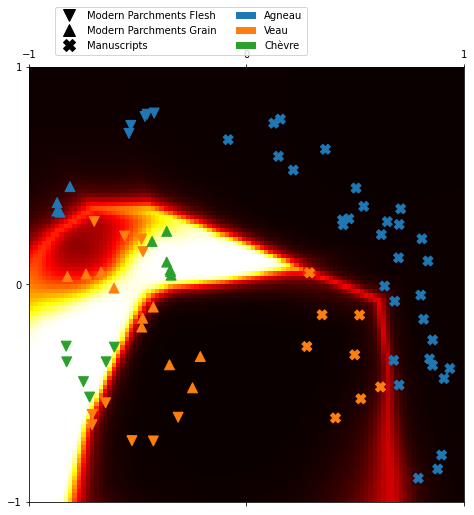

In [191]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
latent, classif = ae.encode(torch.from_numpy(xs).type(torch.float))
latent = latent.detach().numpy()
classif = classif.detach().numpy()
markers = ["v", "^", "X"]
fig, ax = plt.subplots(figsize=(8,8))
#ax.imshow((np.load("../data/colorimetry.npy")), extent=[-1, 1, -1, 1])
#ax.matshow(np.flipud(np.argmax(classes, axis=-1).T), cmap="Paired", extent=[-1, 1, -1, 1])
ax.matshow(np.flipud(classes[:,:,2].T), cmap="hot", extent=[-1, 1, -1, 1])
markerlabel = np.array([ a * 10 + b for a, b in zip( labels[:, 2], labels[:, 3])])
for i, c in enumerate(np.unique(markerlabel)):
    mask = markerlabel == c
    cur = latent[mask,:]
    ax.scatter(*cur.T, c=[f"C{l}" for l in labels[mask, 0].flat], marker=markers[i], s=100)
legend_elements = [Line2D([0], [0], marker="v", markersize=12, color='k', linestyle="", label='Modern Parchments Flesh'),
                   Line2D([0], [0], marker="^", markersize=12, color='k', linestyle="", label='Modern Parchments Grain'),
                   Line2D([0], [0], marker='X', color='k', linestyle="", label='Manuscripts', markersize=12),
                   Patch(facecolor='C0',  label='Agneau'),
                   Patch(facecolor='C1',  label='Veau'),
                   Patch(facecolor='C2',  label='Chèvre'),
                   ]
                
plt.axis("square")
plt.axis([-1, 1, -1, 1])
plt.legend(handles=legend_elements, bbox_to_anchor =(0.65, 1.15), ncol=2)

In [81]:
torch.save(ae.state_dict(), "vae_04.model")
import pickle
pickle.dump(scaler, open("vae_04.scaler", "wb"))

In [82]:
import shap
batch = next(iter(loader))
spectras, = batch
e = shap.DeepExplainer(ae.enc, spectras)
shap_values = e.shap_values(spectras[0:1])

ValueError: too many values to unpack (expected 1)

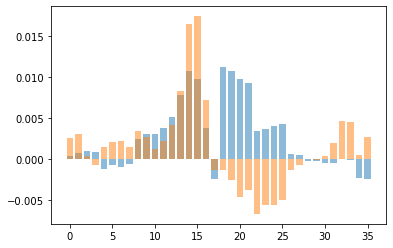

In [408]:
fig, axs = plt.subplots()
for i in range(len(shap_values)//2):
    data = shap_values[i][0][::3].reshape(-1, 8).sum(-1)
    axs.bar(np.arange(len(data)), data, alpha=0.5)

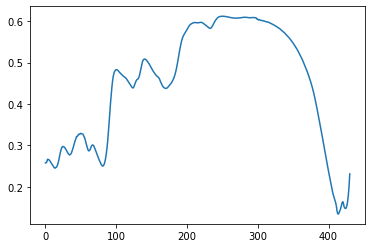

In [407]:
plt.plot(scaler.inverse_transform(spectras).reshape(spectras.shape[0], 2, -1)[0,1])

In [183]:
lx = np.linspace(-1, 1, 100)
from itertools import product
XY = np.array(list(product(lx, lx)), dtype=np.float32)
XY = torch.from_numpy(XY)
classes = ae.classify(ae.dec(XY))
classes = classes.detach().numpy()


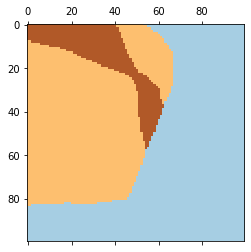

In [184]:
classes = classes.reshape(100, 100, 3)
fig, ax = plt.subplots()
ax.matshow(np.argmax(classes, axis=-1), cmap="Paired")

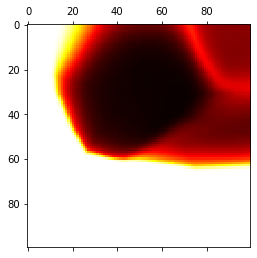

In [129]:
plt.matshow(classes[:,:, 0], cmap="hot")